In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
import sys
import multiprocessing
from psiam_tied_no_dv_map_utils import cum_A_t_fn, all_RTs_fit_OPTIM_fn
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn
from tqdm import tqdm
from scipy.integrate import trapezoid
import random

from psiam_tied_no_dv_map_utils import CDF_E_minus_small_t_NORM_fn_vectorized, rho_A_t_fn_vectorized,P_small_t_btn_x1_x2_vectorized
import time
from scipy.interpolate import interp1d


In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

In [ ]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
print(f'len of LED off rows: {len(df_1)}')
# remove trunc aborts
df_1 = df_1 [ ~( (df_1['abort_event']==3) & (df_1['timed_fix'] < 0.3) ) ]
print(f'len of LED off rows after removing trunc aborts: {len(df_1)}')

df_1 = df_1[df_1['timed_fix'] > df_1['intended_fix']]
print(f'len of rows after reoving all aborts = {len(df_1)}')

In [6]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [7]:
vp_sample = vp.sample(int(1e6))[0]

In [8]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor

In [ ]:
t_A_aff

# VBMC

## loglike fn

In [10]:
t_stim_arr = np.arange(0.2, 2.3, 0.2)
t_pts_for_integ = np.arange(0, 10, 0.001)
tasks = [(ABL, ILD) for ABL in ABL_arr for ILD in ILD_arr]

In [11]:
def P_up_optim_fn(t, V_A, theta_A, x1, x2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max, t_A_aff, t_motor, t_stim):
    return rho_A_t_fn_vectorized(t - t_A_aff - t_motor, V_A, theta_A) * ( CDF_E_minus_small_t_NORM_fn_vectorized(t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) + \
                                                 P_small_t_btn_x1_x2_vectorized(x1, x2, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) )

In [12]:
def compute_integral(ABL, ILD, t_stim_arr, t_pts_for_integ, P_up_optim_fn, V_A, theta_A, x1, x2,
                    rate_lambda, T_0, theta_E, Z_E, bound, K_max, t_A_aff, t_motor):
    integrals = np.zeros_like(t_stim_arr)
    for t_stim_idx, t_stim in enumerate(t_stim_arr):
        unknown_integ_arr = P_up_optim_fn(t_pts_for_integ, V_A, theta_A, x1, x2,
                                    ABL, ILD, rate_lambda, T_0, theta_E, Z_E,
                                    bound, K_max, t_A_aff, t_motor, t_stim)
        integrals[t_stim_idx] = trapezoid(unknown_integ_arr, t_pts_for_integ)
    return ((ABL, ILD), integrals)

In [13]:
def compute_loglike(row, integral_vs_t_stim):
    intended_fix = row['intended_fix']
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    t_stim = intended_fix

    p_up_vs_t_stim = integral_vs_t_stim[(ABL, ILD)]
    cubic_interp_func = interp1d(
        t_stim_arr, 
        p_up_vs_t_stim, 
        kind='cubic', 
        fill_value="extrapolate",  # Allows extrapolation outside the data range
        assume_sorted=True         # Assumes input data is sorted
    )
    p_up = cubic_interp_func(t_stim)


    if choice == 3:
        likelihood = p_up
    elif choice == 2:
        likelihood = 1 - p_up
    
    if likelihood <= 0:
        likelihood = 1e-50

    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, Z_E = params
    
    bound = 1
    K_max = 10
    x1 = 1; x2 = 2
    integral_vs_t_stim = {}
    # start_time = time.time()

    results = Parallel(n_jobs=30)(
        delayed(compute_integral)(
            ABL, ILD, t_stim_arr, t_pts_for_integ, P_up_optim_fn, V_A, theta_A, x1, x2,
            rate_lambda, T_0, theta_E, Z_E, bound, K_max, t_A_aff, t_motor
        ) for (ABL, ILD) in tasks
    )
    integral_vs_t_stim = {}
    for (ABL, ILD), integrals in results:
        integral_vs_t_stim[(ABL, ILD)] = integrals



    # end_time = time.time()
    # print(f"Time taken: {end_time - start_time} seconds")


    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, integral_vs_t_stim)\
                                       for _, row in df_1.iterrows() if (row['timed_fix'] > row['intended_fix']) \
                                        and (row['response_poke'] in [2,3]))

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [14]:
rate_lambda_bounds = [0.01, 0.2]
theta_E_bounds = [30, 60]
T_0_bounds = [0.1*(1e-3), 1*(1e-3)]


# t_E_aff_bounds = [0.001, 0.1]
Z_E_bounds = [-10, 10]
# L_bounds = [0.1, 1.99]

# ---
rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [40, 55]

# t_E_aff_plausible_bounds = [0.01, 0.05]
Z_E_plausible_bounds = [-5, 5]
# L_plausible_bounds = [0.5, 1.5]

## prior

In [15]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, Z_E = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    # L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + Z_E_logpdf


## prior + loglike

In [16]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [ ]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
                Z_E_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                 Z_E_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                 Z_E_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                 Z_E_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
# L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, Z_E_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

In [15]:
vbmc.save('Only_choice_all_trials.pkl')

# Till HERE PYTHON FILE

In [47]:
with open('INTP_PSYCHO_choice_all_trials.pkl', 'rb') as f:
    vp = pickle.load(f)

In [48]:
vp = vp.vp

## corner plots

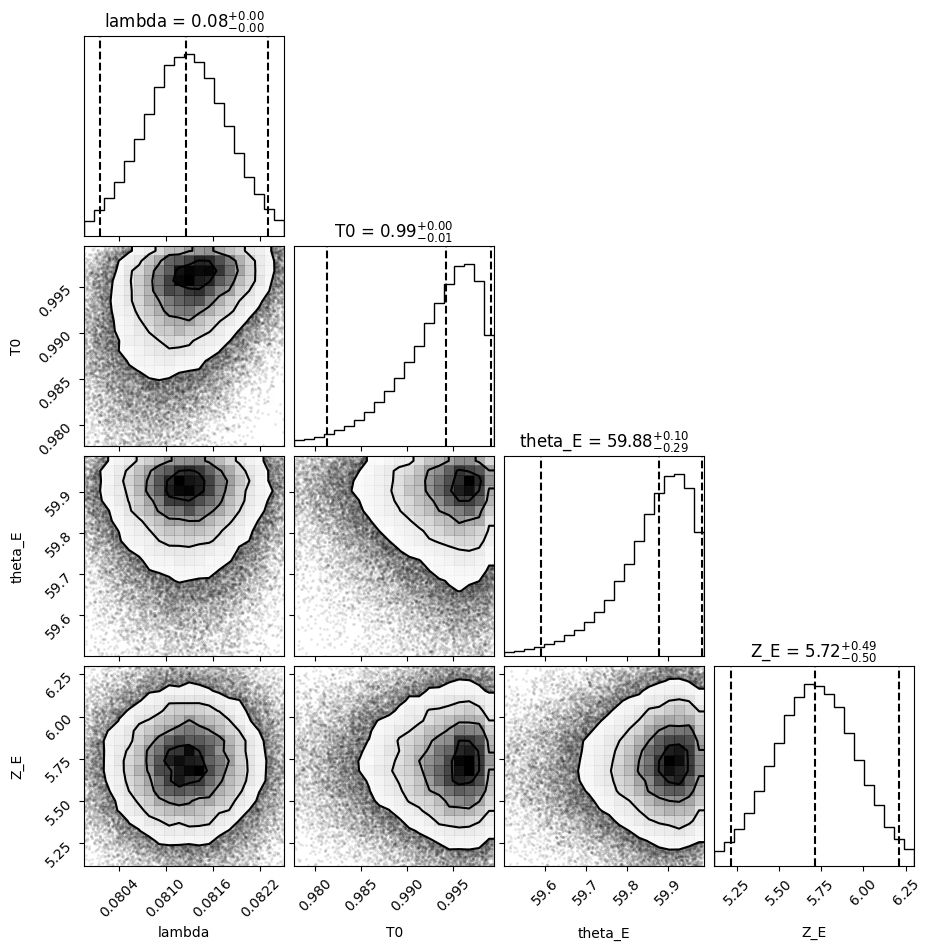

In [51]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 'Z_E']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# diagnose

## simulate data

In [50]:
# lambda_mean = vp_samples[max_idx, 0]
# T0_mean = vp_samples[max_idx, 1] / 1e3
# theta_E_mean = vp_samples[max_idx, 2]

In [21]:
# print(f'lambda = {lambda_mean}')
# print(f't0 = {T0_mean * 1000} ms')
# print(f'theta E = {theta_E_mean}')

In [52]:
lambda_mean = np.mean(vp_samples[:,0])
T0_mean = np.mean(vp_samples[:,1]) / 1e3
theta_E_mean = np.mean(vp_samples[:,2])

Z_E_mean = np.mean(vp_samples[:,3])

# t_E_aff_mean = vp_samples[max_idx, 3]
# Z_E_mean = vp_samples[max_idx, 4]
# L_mean = vp_samples[max_idx, 5]


In [53]:
print(f'likelihood = {psiam_tied_loglike_fn([lambda_mean, T0_mean, theta_E_mean, Z_E_mean]):.3f} ')

likelihood = -21968.899 


In [54]:
N_print = 50_000 + 1
dt = 1e-3
N_sim = int(1e6)
# L_mean = 1
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)

t_E_aff = 0.03
# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
#                                                                          t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 
from psiam_tied_no_dv_map_utils import psiam_tied_data_gen_wrapper_no_L_v2
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_no_L_v2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean,\
                                                                                theta_E_mean, Z_E_mean, t_stim_sampled[iter_num], t_A_aff, t_E_aff, t_motor, dt)\
                                                                                     
                                                                                      for iter_num in range(N_sim))


# Generic class for diagnostics

In [55]:
class Diagnostics:
    """
    Remove truncated aborts by urself

    data frame with column names
    rt: RT wrt fixation
    t_stim: stimulus onset
    choice: 1 or -1
    ABL, ILD
    correct: 1 or 0
    """
    def __init__(self, data):
        self.data = data

    def plot_rtd_wrt_fix(self,bins):
        """
        return x and y for plotting
        """
        df = self.data.copy()
        rt_wrt_fix = df['rt']
        rt_wrt_fix_hist, _ = np.histogram(rt_wrt_fix, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_fix_hist
    

    def plot_rtd_wrt_stim(self,bins):
        df = self.data.copy()
        rt_wrt_stim = df['rt'] - df['t_stim']
        rt_wrt_stim_hist, _ = np.histogram(rt_wrt_stim, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_stim_hist

    def plot_tacho(self, bins):
        # prob of correct vs RT
        df = self.data.copy()
        df['RT_bin'] = pd.cut(df['rt'] - df['t_stim'], bins=bins, include_lowest=True)
        grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
        return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']
    
    def plot_chrono(self):
        # mean rt vs abs ILD for each ABL
        df = self.data.copy()
        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        abl_rt_dict = {}

        for ABL in all_ABL:
            per_ILD_rt = np.zeros_like(all_ILD)
            for idx, ILD in enumerate(all_ILD):
                filtered_df = df[ (df['ABL'] == ABL) \
                                            & (df['ILD'].isin([ILD, -ILD])) ]
                mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
                per_ILD_rt[idx] = mean_rt
            abl_rt_dict[ABL] = per_ILD_rt
        
        return all_ILD, abl_rt_dict

    def plot_quantile(self):
        # 10 - 90 percentiles in steps of 20
        df = self.data.copy()
        df['rt_wrt_stim'] = df['rt'] - df['t_stim']

        abl_ild_quantiles = {}
        quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        for abl in all_ABL:
            abl_ild_quantiles[abl] = {}
            for ild in all_ILD:
                filtered_df = df[(df['ABL'] == abl) & (df['ILD'].isin([ild, -ild]))]
                quantiles = filtered_df['rt_wrt_stim'].replace([np.nan, np.inf, -np.inf], np.nan).dropna().quantile(quantile_levels).tolist()
                abl_ild_quantiles[abl][ild] = quantiles

        return abl_ild_quantiles
    
    def plot_psycho(self):
        df = self.data.copy()
        prob_choice_dict = {}

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())

        for abl in all_ABL:
            filtered_df = df[df['ABL'] == abl]
            prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

        return prob_choice_dict



In [56]:
T_trunc_left_aborts = 0.3

# design diag

In [57]:
# sim
# remove trunc aborts
sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
# remove right trunc valid trials
# sim_results_2 = [res for res in sim_results_1 if res['rt'] - res['t_stim'] < T_trunc_right_wrt_stim]
sim_results_2 = sim_results_1

for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

# all trials df
sim_results_pd_valid = pd.DataFrame(sim_results_2)
# only valid trials df
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj = Diagnostics(sim_results_pd_valid)
sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

# data
df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

# remove trunc aborts
df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
# right trunc
# df_led_off_trunc_1 =  df_led_off_trunc[df_led_off_trunc['rt'] - df_led_off_trunc['t_stim'] < T_trunc_right_wrt_stim]
df_led_off_trunc_1 = df_led_off_trunc
# only valid
df_led_off_trunc_1_valid = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]

data_diagnose_obj = Diagnostics(df_led_off_trunc_1)
data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1_valid)

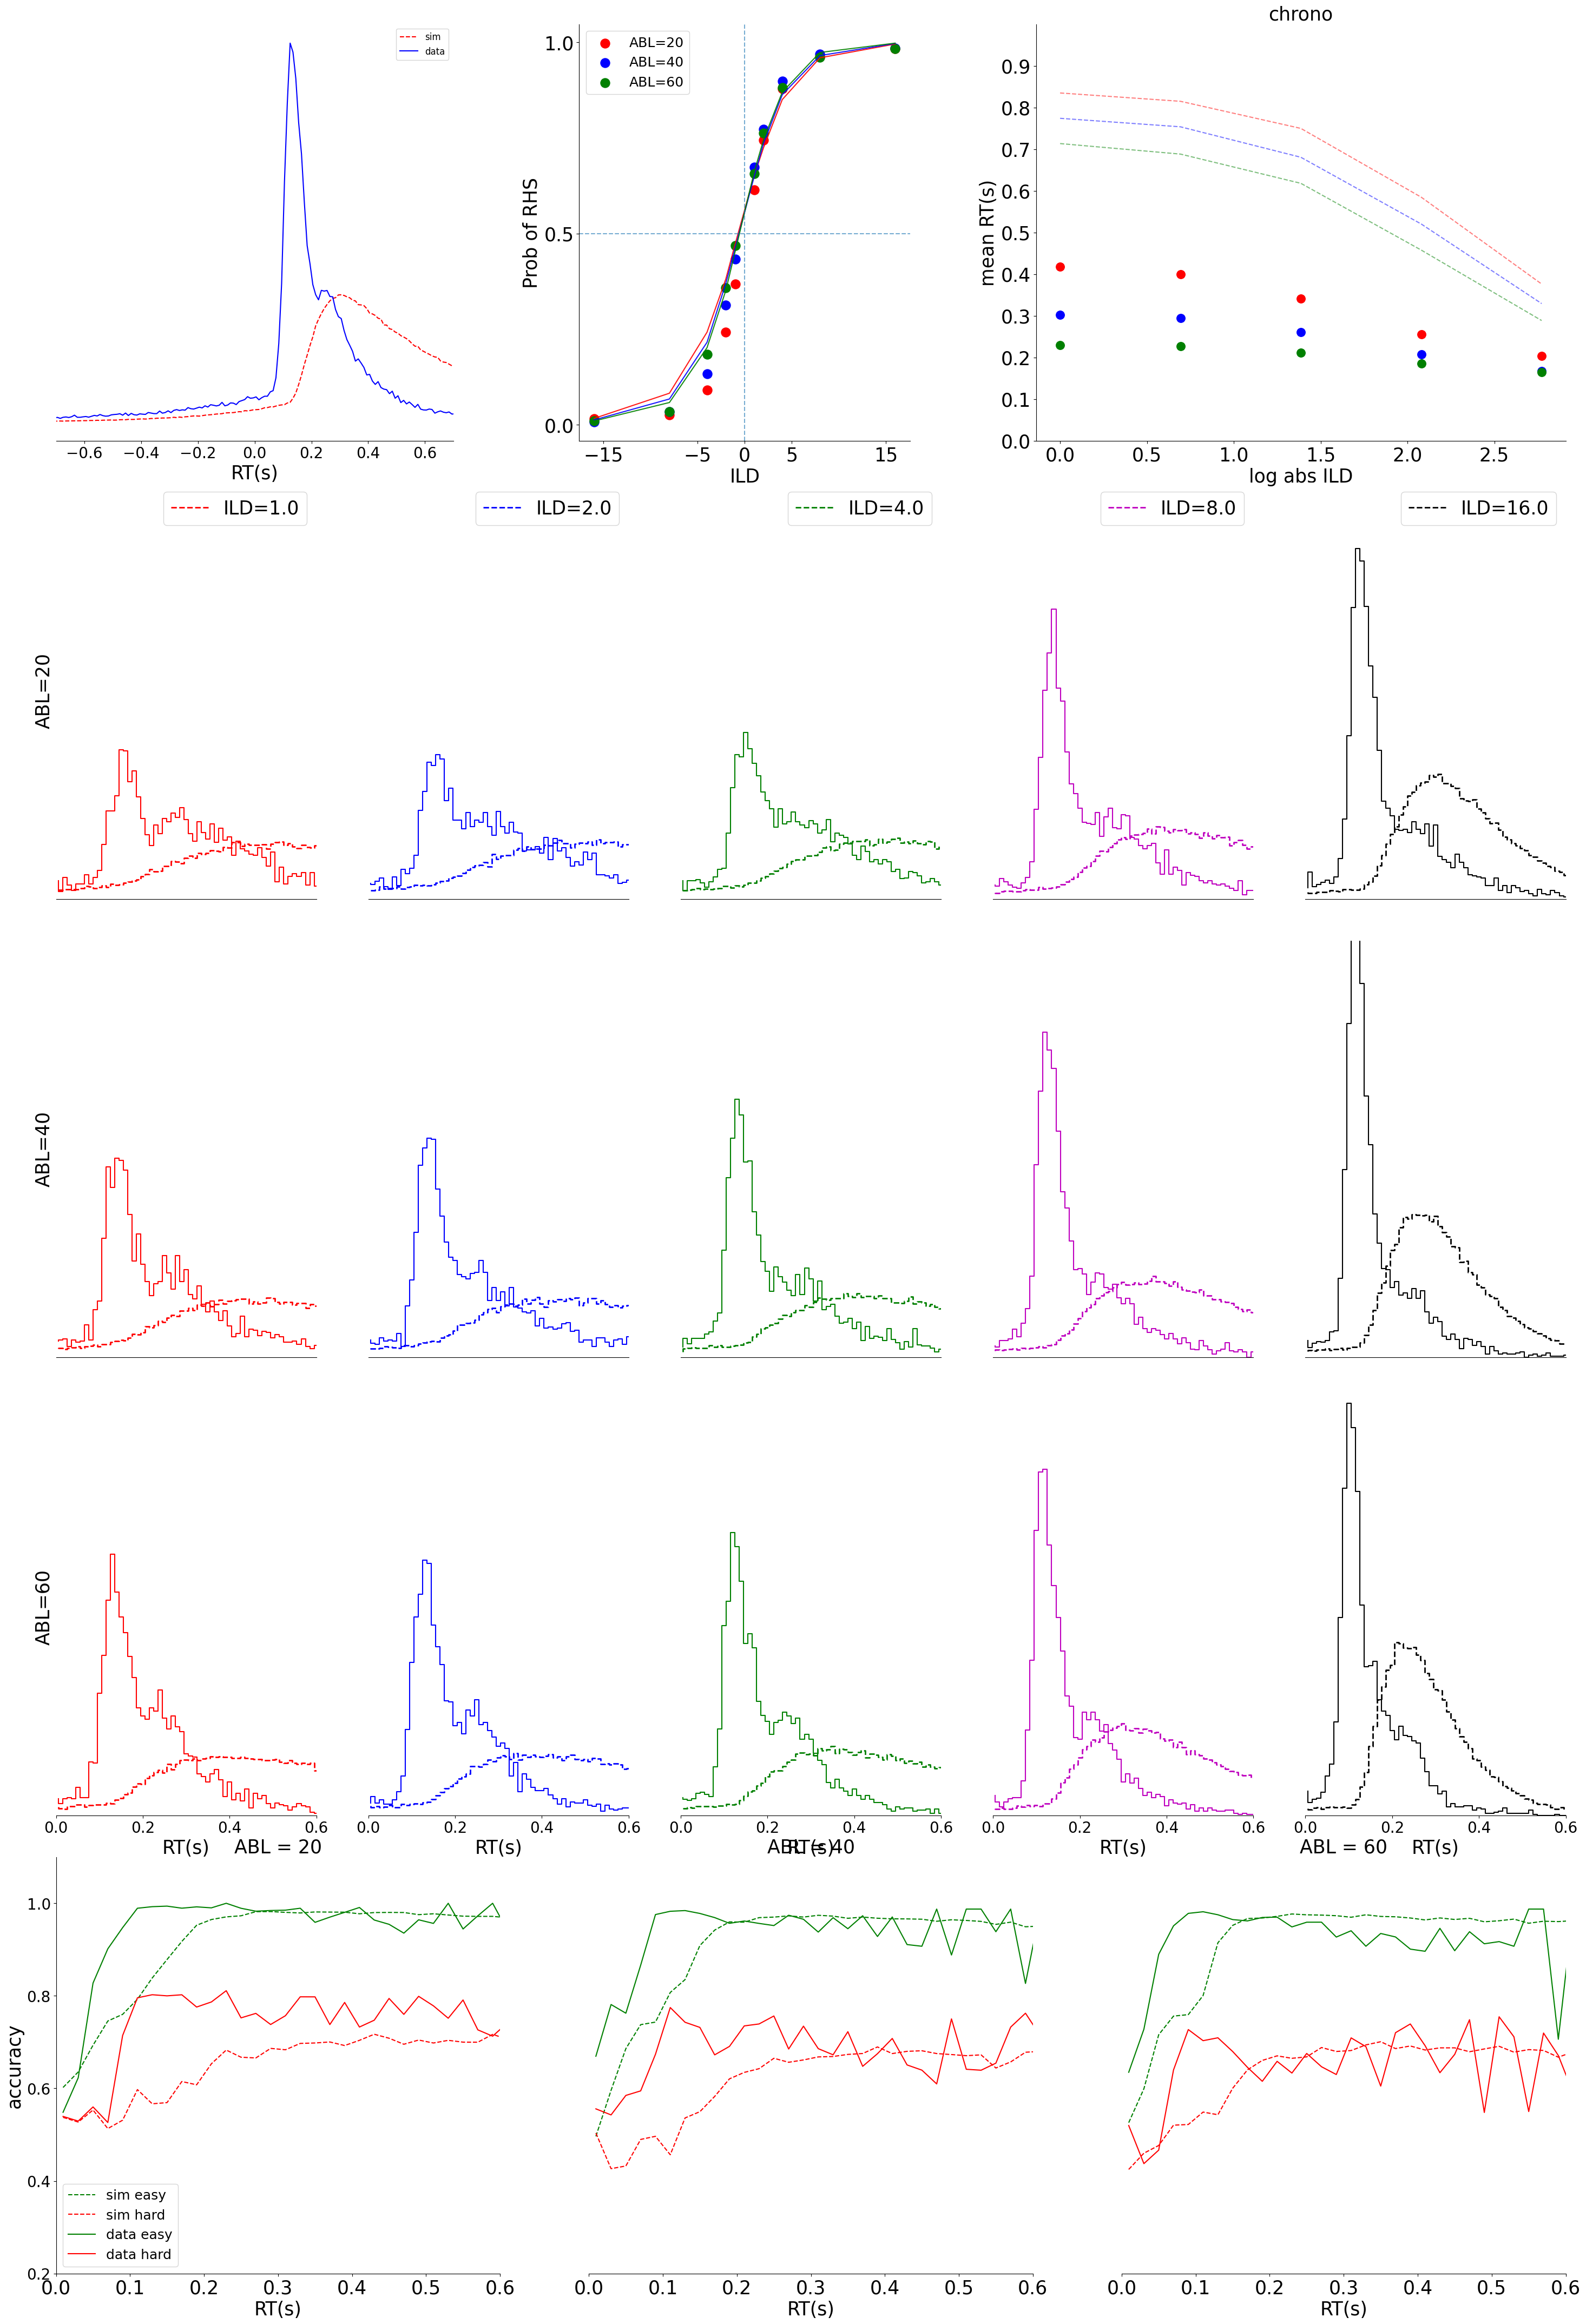

In [58]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

# ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)

# 1 - psycho 
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
# ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax_chrono.plot(np.log(x), sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax_chrono.scatter(np.log(x), data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 1)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 1, 0.1))

# RTDs per ABL
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim', linewidth=2)

        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
        ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color=ILD_colors[ILD])

        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)



In [ ]:
sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
# sim_results_2 = [res for res in sim_results_1 if res['rt'] - res['t_stim'] < T_trunc_right_wrt_stim] 
sim_results_2 = sim_results_1

df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
# df_led_off_trunc_1 =  df_led_off_trunc[df_led_off_trunc['rt'] - df_led_off_trunc['t_stim'] < T_trunc_right_wrt_stim]
df_led_off_trunc_1 = df_led_off_trunc

sim_diagnose_obj = Diagnostics(pd.DataFrame(sim_results_2))
data_diagnose_obj = Diagnostics(df_led_off_trunc_1)

fig = plt.figure(figsize=(30, 25))
gs = fig.add_gridspec(3, 2)

### PLOT 1
ax1 = fig.add_subplot(gs[0, 0])
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='sim', ls='--', color='r')
x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='data', color='b')
ax1.set_title('right trunc, trunc aborts removed RTD')
ax1.set_xlabel('rt - t_stim')
ax1.set_ylabel('density')
ax1.legend()

data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']])
for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

sim_results_pd_valid = pd.DataFrame(sim_results_2)
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

### PLOT 2
ax2 = fig.add_subplot(gs[0, 1])
ABL_colors = {20: 'b', 40: 'r', 60: 'k'}
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax2.plot(x, sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax2.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
ax2.legend()
ax2.set_xlabel('abs ILD')
ax2.set_ylabel('mean RT')
ax2.set_title('chrono')

### PLOT 3
gs_row1 = gs[1, :].subgridspec(1, 3)
for idx, ABL in enumerate(data_diagnose_obj_valid.plot_quantile().keys()):
    ax = fig.add_subplot(gs_row1[0, idx])

    data_q = data_diagnose_obj_valid.plot_quantile()
    sim_q = sim_diagnose_obj_valid.plot_quantile()
    all_ild = data_q[ABL].keys()
    for ild in all_ild:
        ax.scatter(np.log(ild*np.ones_like(data_q[ABL][ild])), data_q[ABL][ild], color='b', s=250)
        ax.scatter(np.log(ild*np.ones_like(sim_q[ABL][ild])), sim_q[ABL][ild], marker='x', color='r', s=250)
    ax.set_title(f'Quantile Plot ABL={ABL}')
    ax.set_xlabel('log_2 abs ILD')
    ax.set_ylim(0, 0.21)




### PLOT 4
ax4 = fig.add_subplot(gs[2, 0])
bins = np.arange(0, 0.3, 0.005)
x, data_tacho = data_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, data_tacho, label='data', color='b')
x, sim_tacho = sim_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, sim_tacho, label='sim', color='r', ls='--')
ax4.legend()
ax4.set_xlabel('rt - t_stim')
ax4.set_ylabel('prob of correct')
ax4.set_title('tacho for trials btn t_stim and t_stim + 0.21s')

### PLOT 5
ax5 = fig.add_subplot(gs[2, 1])
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax5.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax5.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax5.set_xlabel('ILD')
ax5.set_ylabel('Prob of RHS')
ax5.set_title('rt btn t_stim and t_stim + 0.21')
ax5.legend()

plt.tight_layout()
plt.show()


In [94]:
# sim
# remove trunc aborts
sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
# remove right trunc valid trials
sim_results_2 = sim_results_1
for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

# all trials df
sim_results_pd_valid = pd.DataFrame(sim_results_2)
# only valid trials df
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj = Diagnostics(sim_results_pd_valid)
sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

# data
df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

# remove trunc aborts
df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
# right trunc
df_led_off_trunc_1 =  df_led_off_trunc
# only valid
df_led_off_trunc_1_valid = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]

data_diagnose_obj = Diagnostics(df_led_off_trunc_1)
data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1_valid)

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)

# 1 - psycho 
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax_chrono.plot(np.log(x), sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax_chrono.scatter(np.log(x), data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 1)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 0.5, 0.1))

# RTDs per ABL
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim', linewidth=2)

        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
        ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color=ILD_colors[ILD])

        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)



# tacho stim wise

In [ ]:
data_only_valid_1 = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]

pos_ILD = all_ILD[ all_ILD > 0]
f = 1
bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20, 40))
for ILD in pos_ILD:
    for ABL in ABL_arr:
        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_pd_obj = Diagnostics(sim_pd)
        x, sim_tacho = sim_pd_obj.plot_tacho(bins)

        data_pd = data_only_valid_1[ (data_only_valid_1['ABL'] == ABL) & (data_only_valid_1['ILD'].isin([ILD, -ILD]))]
        data_pd_obj = Diagnostics(data_pd)
        x, data_tacho = data_pd_obj.plot_tacho(bins)

        plt.subplot(len(pos_ILD), len(ABL_arr), f)

        plt.plot(x, sim_tacho, color='r', ls='--', label='sim')
        plt.plot(x, data_tacho, color='b', label='sim', alpha=0.5)
        plt.legend()
        plt.xlabel('rt wrt stim')
        plt.ylabel('accuracy')
        plt.title(f'tacho abl={ABL},abs ILD={ILD}');
        plt.ylim(0, 1);
        f += 1
        



# stim wise distr

In [ ]:
data_only_valid_1 = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]
pos_ILD = all_ILD[ all_ILD > 0]
f = 1
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20, 40))
for ILD in pos_ILD:
    for ABL in ABL_arr:
        plt.subplot(len(pos_ILD), len(ABL_arr), f)

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = data_only_valid_1[ (data_only_valid_1['ABL'] == ABL) & (data_only_valid_1['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        # plt.hist(sim_rt, bins=bins, density=True, histtype='step', linestyle='--', color=ABL_colors[ABL])
        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        plt.step(t_pts,sim_rt_hist, linestyle='--', label='sim', color='r')

        plt.hist(data_rt, bins=bins, density=True, histtype='step', label='data', color='b')

        plt.xlabel('rt wrt stim')
        plt.ylabel('density')
        plt.legend()
        plt.title(f'ABL = {ABL}, abs ILD={ILD}')
        f += 1

# tacho to find sesnory delay

In [ ]:
df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']
df_led_off_valid = df_led_off[ df_led_off['rt'] > df_led_off['t_stim'] ]

ABL = 60; ILD = 16
df_led_off_valid_ABL_ILD = df_led_off_valid[ (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'].isin([ILD, -ILD])) ]

bins=np.arange(0, 1, 0.001)
plt.hist(df_led_off_valid_ABL_ILD['rt']-df_led_off_valid_ABL_ILD['t_stim'], bins=bins, density=True);
plt.xlim(0, 0.1)
xticks = np.arange(0, 0.1, 0.01)
plt.xticks(xticks);

# param play

In [ ]:
lam_times_theta = vp_samples[:,0] * vp_samples[:,2]
plt.hist(lam_times_theta, density=True, bins=100, histtype='step');
plt.xlabel('lambda x theta_E')
plt.ylabel('density');

In [ ]:
max(vp_samples[:,0]) * max(vp_samples[:,2])
lambda_mean * theta_E_mean

# see fraction of different sets of trials

In [ ]:
############ trunc ABORTS  ##########

# --- sim---
# num_aborts = np.sum([1 for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3])
num_aborts = np.sum([1 for res in sim_results if res['rt'] < res['t_stim']])

frac_aborts = num_aborts / len(sim_results)
print(f'sim frac aborts: {frac_aborts}')

# --- data ---
data_df = df.copy();
data_df_led_off = data_df[ data_df['LED_trial'] == 0 ]
data_df_trunc_aborts = data_df_led_off[ (data_df_led_off['timed_fix'] < data_df_led_off['intended_fix']) & (data_df_led_off['timed_fix'] > 0.3) ]
frac_aborts_data = len(data_df_trunc_aborts) / len(data_df_led_off)
print(f'data frac aborts: {frac_aborts_data}')

# -- theory ---
N_sim = 100_000
t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)
def compute_trunc_frac_aborts_fn(t_stim):
    trunc_factor = 1 - cum_A_t_fn(0.3 - t_A_aff - t_motor, V_A, theta_A)
    frac_aborts = cum_A_t_fn(t_stim - t_A_aff - t_motor, V_A, theta_A) / (trunc_factor + 1e-10)
    return frac_aborts


results = Parallel(n_jobs=30)(delayed(compute_trunc_frac_aborts_fn)(t_stim) for t_stim in t_stim_sampled)
frac_aborts_theory = np.mean(results)
print(f'theory frac aborts: {frac_aborts_theory}')

# truncated RT wrt stim

In [ ]:
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]


data_df.loc[:, 'rt_wrt_stim'] = df['timed_fix'] - df['intended_fix']
print(f'len of data_df: {len(data_df)}')
data_df = data_df[ ~((data_df['abort_event'] == 3) & (data_df['timed_fix'] < 0.3)) ]
print(f'len of data_df: {len(data_df)}')

right_trunc_rt_wrt_stim = data_df[ (data_df['rt_wrt_stim'] < T_trunc_right_wrt_stim) ]['rt_wrt_stim']
bins = np.arange(-2, 0.3, 0.01)
plt.hist(right_trunc_rt_wrt_stim, bins=bins, density=True, label='data', histtype='step');

# sim
right_truncated_rt_wrt_stim_SIM = [res['rt'] - res['t_stim'] for res in sim_results if  \
                                    res['rt'] - res['t_stim'] < T_trunc_right_wrt_stim and \
                                        not (res['rt'] < res['t_stim'] and res['rt'] < 0.3)]
plt.hist(right_truncated_rt_wrt_stim_SIM, bins=bins, density=True, label='sim', histtype='step');
plt.legend();
plt.xlabel('RT wrt stim');
plt.ylabel('Density');
plt.title('all trials < 0.21s, with aborts < 0.3 removed')
plt.xlim(-1,0.3)

# is there a issue due to aligning to t_stim, see wrt fix

In [ ]:
V_A, theta_A, t_A_aff, t_motor

In [26]:
N_sim = 100_000
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)
t_pts = np.arange(0, 2, 0.05)
pro_pdf_vs_t_stim = np.zeros((N_sim, len(t_pts)))
def compute_pdf(t_stim):
    pro_pdf = np.zeros_like(t_pts)
    if t_stim < 0.3:
        return np.nan * np.zeros_like(t_pts)
    for t_id, t in enumerate(t_pts):
        if t < 0.3 or t > t_stim:
            pro_pdf[t_id] = 0
        else:
            pro_pdf[t_id] = rho_A_t_fn(t - t_A_aff, V_A, theta_A)

    return pro_pdf 

def compute_cdf(t_stim):
    area =  cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) - cum_A_t_fn(0.3 - t_A_aff, V_A, theta_A)
    if area < 0:
        area = np.nan
    return area

In [ ]:
results = Parallel(n_jobs=30)(delayed(compute_pdf)(t_stim) for t_stim in tqdm(t_stim_sampled))

In [ ]:
results_cdf = Parallel(n_jobs=30)(delayed(compute_cdf)(t_stim) for t_stim in tqdm(t_stim_sampled))

In [ ]:
results_cdf_np = np.array(results_cdf)
# remove nan
results_cdf_no_nan = results_cdf_np[~np.isnan(results_cdf_np)]
np.mean(results_cdf_no_nan)

In [ ]:
pro_pdf_np = np.array(results)
pro_pdf_np_mean = np.nanmean(pro_pdf_np, axis=0)
print(f'area under the curve: {np.trapz(pro_pdf_np_mean, t_pts)}')  

In [ ]:
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]
data_df_aborts = data_df[data_df['abort_event'] == 3]
data_df_trunc_aborts_rt_wrt_fix = data_df_aborts[ data_df_aborts['timed_fix'] > 0.3 ]['timed_fix']
frac_of_aborts = len(data_df_trunc_aborts_rt_wrt_fix) / len(data_df) 
print(f'frac of aborts: {frac_of_aborts}')

In [ ]:
bins = np.arange(0, 2, 0.01)
data_aborts_hist, _ = np.histogram(data_df_trunc_aborts_rt_wrt_fix, bins=bins, density=True)
data_aborts_hist *= frac_of_aborts

plt.plot(bins[:-1], data_aborts_hist, label='data')
plt.plot(t_pts, pro_pdf_np_mean, label='theory');

print(f'area under pro_pdf_np_mean: {np.trapz(pro_pdf_np_mean, t_pts)}')    
print(f'area under data_aborts_hist: {np.trapz(data_aborts_hist, bins[:-1])}')

trunc_aborts_wrt_fix = [res['rt'] for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3]
sim_hist, _ = np.histogram(trunc_aborts_wrt_fix, bins=bins, density=True)
sim_hist *= len(trunc_aborts_wrt_fix) / len(sim_results)
print(f'area under sim_hist: {np.trapz(sim_hist, bins[:-1])}')
plt.plot(bins[:-1], sim_hist, label='sim');
plt.legend();
plt.title('truncated aborts wrt fix');


In [ ]:
# aborts > 0.3
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]
data_df_aborts = data_df[data_df['abort_event'] == 3]
data_df_trunc_aborts_rt_wrt_fix = data_df_aborts[ data_df_aborts['timed_fix'] > 0.3 ]['timed_fix']


bins = np.arange(0, 2, 0.01);
plt.hist(data_df_trunc_aborts_rt_wrt_fix, bins=bins, density=True, label='data', histtype='step');

# sim
trunc_aborts_wrt_fix = [res['rt'] for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3]
plt.hist(trunc_aborts_wrt_fix, bins=bins, density=True, label='sim', histtype='step');
plt.legend();

## valid rt wrt stim

In [ ]:
plt.figure(figsize=(15,10))
rt_wrt_stim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
bins = np.arange(0, 2, 0.01)
plt.hist(rt_wrt_stim, bins=bins, density=True, histtype='step', label='vp params');

data_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']
plt.hist(data_rt_wrt_stim, bins=bins, density=True, histtype='step', color='red', label='data');
plt.xlabel('RT - Stimulus (s)');    
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt stim')
# plt.xlim(-1,1)
plt.grid(True)
plt.xlim(0,0.4)
xticks = np.arange(0, 0.4, 0.01)
plt.xticks(xticks, [f'{x:.2f}' for x in xticks]);

## valid rt wrt fix

In [ ]:
rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
data_rt = df_1['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(data_rt, bins=bins, density=True, histtype='step', color='red', label='data');

plt.xlabel('RT (s) wrt fix');
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt fix')


## all rt wrt fix

In [ ]:
all_rt = [res['rt'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt inclding aborts wrt fix')

# all rt wrt fix, trunc aborts removed

In [ ]:
all_rt = [res['rt'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt fix');

## all rt wrt stim

In [ ]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data', ls='--');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt wrt stim');

# all rt wrt stim trunc aborts removed

In [ ]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt stim');

## psychometric

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ]
sim_results_valid_df = sim_results_valid_df.copy()

sim_results_valid_df.loc[:, 'RHS'] = (sim_results_valid_df['choice'] > 0).astype(int)
sim_grouped = sim_results_valid_df.groupby('ILD')['RHS'].mean().reset_index()

# data
data_df = df_1.copy()
data_df.loc[:, 'RHS'] = (data_df['response_poke'] == 3).astype(int)
data_grouped = data_df.groupby('ILD')['RHS'].mean().reset_index()

plt.plot(data_grouped['ILD'], data_grouped['RHS'], label='data', marker='o', color='red');
plt.plot(sim_grouped['ILD'], sim_grouped['RHS'], label='vp params', marker='o');
plt.xlabel('ILD (dB)');
plt.ylabel('P(RHS)');
plt.legend();

## tachometric

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

# sim results
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ].copy()
sim_results_valid_df.loc[:, 'correct'] = (sim_results_valid_df['choice'] * sim_results_valid_df['ILD'] > 0)
sim_results_valid_df.loc[:, 'rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

sim_results_valid_df['rt_bin'] = pd.cut(sim_results_valid_df['rt_wrt_stim'], bins=bins, right=False)
sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, sim_grouped['correct'], linestyle='-', label='sim', color='b')

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

data_df['rt_bin'] = pd.cut(data_df['rt_wrt_stim'], bins=bins, right=False)
data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, data_grouped['correct'], linestyle='-', label=' data', color='r')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('P(Correct)');
plt.legend();


# tachometric ABL wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

plt.figure(figsize=(20, 5))

ABL_values = np.sort(df_1['ABL'].unique())
colors = ['b', 'g', 'r']  # You can pick your own color scheme
a = 1
for abl_val, c in zip(ABL_values, colors):
    plt.subplot(1, len(ABL_values), a)
    # --- 1) Filter SIM dataframe for the given ABL value ---
    sim_sub = sim_results_valid_df[sim_results_valid_df['ABL'] == abl_val].copy()
    # Bin the RT values
    sim_sub['rt_bin'] = pd.cut(sim_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    sim_grouped = sim_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot SIM result (solid line)
    plt.plot(bin_centers, sim_grouped['correct'], 
            linestyle='-', 
            color=c, 
            label=f'Sim ABL={abl_val}')
    
    # --- 2) Filter DATA dataframe for the given ABL value ---
    data_sub = data_df[data_df['ABL'] == abl_val].copy()
    # Bin the RT values
    data_sub['rt_bin'] = pd.cut(data_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    data_grouped = data_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot DATA result (dashed line)
    plt.plot(bin_centers, data_grouped['correct'], 
            linestyle='--', 
            color=c, 
            label=f'Data ABL={abl_val}')

        # Cosmetics
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('P(Correct)')
    plt.ylim([0.3, 1])  # If you want to fix y-limits
    plt.xlim(0, 0.5)
    plt.legend()
    a += 1



# investigate second bump

In [ ]:
low_rt = 0.2
high_rt = 0.3

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='Data', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='All Data', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('Second Bump Data Distribution')

In [ ]:
# Assuming `trial` column in df_second_bump contains integer values
# Create a list of trials minus 1
trial_minus_1 = df_second_bump['trial'] - 1

# Filter rows from df_1 where the trial column matches the values in trial_minus_1
filtered_df = og_df[og_df['trial'].isin(trial_minus_1)]

# Display the filtered dataframe
abort_event = filtered_df['abort_event']

abort_event_counts = abort_event.value_counts()
abort_event_counts.plot(kind="bar", edgecolor="black")
plt.title(f'Abort event count of trial - 1 for second bump data btn {low_rt} and {high_rt} s')

In [26]:
# Ensure the DataFrame index is reset to align with row positions
df = df.reset_index(drop=True)

# Create a mask to identify rows where the conditions are met
mask = df.apply(
    lambda row: (
        row['trial'] > 1  # Ensure trial-1 is a valid index
        and (row['trial'] - 1) in df.index  # Check trial-1 exists in the DataFrame index
        and df.iloc[int(row['trial']) - 1]['abort_event'] == 3  # Check abort_event in trial-1
        and row['ABL'] == df.iloc[int(row['trial']) - 1]['ABL']  # Match ABL with trial-1
        and row['ILD'] == df.iloc[int(row['trial']) - 1]['ILD']  # Match ILD with trial-1
        and row['success'] == 1
    ),
    axis=1
)

# Remove the rows that meet the condition
df_removed_repeats = df[~mask]


In [27]:
df_removed_repeats_led_off_valid_trials = df_removed_repeats[ (df_removed_repeats['LED_trial'] == 0) & \
                                                             (df_removed_repeats['success'] == 1) ]

In [ ]:
rt_wrt_stim_df_non_repeat = df_removed_repeats_led_off_valid_trials['timed_fix'] \
    - df_removed_repeats_led_off_valid_trials['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(rt_wrt_stim_df_non_repeat, bins=bins, density=True, histtype='step', label='data');
plt.title('valid rt wrt stim, no repeat trials')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');



# see animal wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

animals = df_1['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1

for animal in animals:
    animal_data = df_1[ df_1['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.title(f'valid rt wrt stim, Animal={animal}')
    a += 1


    

In [ ]:
except_animals = [92, 93, 98]
df_1_except = df_1[ ~df_1['animal'].isin(except_animals) ]

df_1_except_animals_rt_wrt_stim = df_1_except['timed_fix'] - df_1_except['intended_fix']
df_1_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(df_1_rt_wrt_stim, bins=bins, density=True, histtype='step', label='all', ls='--');
plt.hist(df_1_except_animals_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'removed except {except_animals}');
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.title(f'valid rt wrt stim, except {except_animals}');
plt.legend();

# df led on also?

In [ ]:
df_led_on = df [ df['LED_trial'] == 1 ]
df_led_on_valid_trials = df_led_on[ df_led_on['success'] == 1 ]
led_on_rt_wrt_stim = df_led_on_valid_trials['timed_fix'] - df_led_on_valid_trials['intended_fix']

led_off_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(led_on_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
plt.hist(led_off_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b', alpha=0.6);
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.legend();
plt.title('all animals valid rt wrt stim');

In [ ]:
# animal wise LED on

animals = df_led_on['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1
for animal in animals:
    animal_data = df_led_on_valid_trials[ df_led_on_valid_trials['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ON,  Animal={animal}')
    a += 1
    

# plot RTs as func of ABL

In [ ]:
plt.figure(figsize=(20, 5))
a = 1
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
    plt.subplot(1, len(ABL_arr), a)
    plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ABL={ABL}')
    a += 1
    


In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,30))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    for ABL in ABL_arr:
        plt.subplot(5, 3, a)

        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
        plt.xlabel('RT - Stimulus (s)');
        plt.ylabel('density')
        plt.title(f'abs ILD={ILD}')
        plt.legend();
        a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,5))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    plt.subplot(1,6, a)
    for ABL in ABL_arr:
        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ILD={ILD}')
    plt.legend();
    a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,15))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    plt.subplot(3,1, a)
    for ILD in pos_ILD:
        ILD_data = ABL_data[ (ABL_data['ILD'] == ILD) | (ABL_data['ILD'] == -ILD) ]
        ILD_rt_wrt_stim = ILD_data['timed_fix'] - ILD_data['intended_fix']
        plt.hist(ILD_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ILD={ILD}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ABL={ABL}')
    a += 1

# all animals on and off

In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']

    plt.subplot(1, len(animals), a)
    plt.hist(animal_on_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
    plt.hist(animal_off_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1



In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']
    plt.subplot(1, len(animals), a)
    # hist on - hist off
    hist_on, _ = np.histogram(animal_on_valid_rt_wrt_stim, bins=bins, density=True)
    hist_off, _ = np.histogram(animal_off_valid_rt_wrt_stim, bins=bins, density=True)

    plt.plot(bins[:-1], hist_on - hist_off, label='LED ON - LED OFF');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1

